In [1]:
import numpy as np
import os
import cv2
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from sklearn.preprocessing import normalize

## LBP-TOP features from the data

In [33]:
# LBP parameters
radius = 1  # Radius of LBP
n_points = 8 * radius  # Number of points in LBP

# Define the path to the dataset
dataset_path = r'C:\Users\venla\Documents\Affective_computing\Project\OriginalImg\NI\Dark'

# Define the emotion labels and their corresponding numeric values
emotion_labels = {
    'Anger': 0,
    'Disgust': 1,
    'Fear': 2,
    'Happiness': 3,
    'Sadness': 4,
    'Surprise': 5
}

1. Reading the dataset

In [50]:

# Function to align face using eye landmarks
def align_face(image, landmarks):
    left_eye = (landmarks[36] + landmarks[39]) // 2
    right_eye = (landmarks[42] + landmarks[45]) // 2
    # Calculate angle between eyes
    dY = right_eye[1] - left_eye[1]
    dX = right_eye[0] - left_eye[0]
    angle = np.degrees(np.arctan2(dY, dX))
    # Compute center of the eyes
    center = ((int(left_eye[0] + right_eye[0]) // 2), int((left_eye[1] + right_eye[1]) // 2))
    # Rotate image to align eyes horizontally
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    aligned_face = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return aligned_face

In [49]:
def preprocess_image(image_path, detector, predictor):
    # Read the image and convert to grayscale
    #image = rgb2gray(cv2.imread(image_path))
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2GRAY)
    # Detect face and landmarks
    faces = detector(image)
    for face in faces:
        landmarks = predictor(image, face)
        landmarks = np.array([[p.x, p.y] for p in landmarks.parts()])
        aligned_face = align_face(image, landmarks)
        
        # Normalize the aligned face using histogram equalization
        normalized_face = cv2.equalizeHist(aligned_face)           
        # Resize image
        preprocessed_image = cv2.resize(normalized_face,(128,128))

    return preprocessed_image

In [51]:
import dlib

# Load Dlib’s face detector and shape predictor (landmarks)
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# Arrays to store images and corresponding labels
image_data = []
labels = []

# Supported image formats
supported_image_formats = ('.jpg', '.jpeg', '.png')

# Traverse the dataset folder
for subject_folder in os.listdir(dataset_path):
    subject_path = os.path.join(dataset_path, subject_folder)
    
    # Check if it's a directory
    if os.path.isdir(subject_path):
        # Traverse each emotion folder within each subject folder
        for emotion_folder in os.listdir(subject_path):
            emotion_path = os.path.join(subject_path, emotion_folder)
            
            # Check if it's a directory and corresponds to a valid emotion
            if os.path.isdir(emotion_path) and emotion_folder in emotion_labels:
                # Get the numeric label for the emotion
                label = emotion_labels[emotion_folder]
                # Array to store the frames in one video
                emotion_data = []
                # Traverse all the files in the emotion folder
                for image_file in os.listdir(emotion_path):
                    # Only process files with valid image extensions
                    if image_file.endswith(supported_image_formats):
                        image_path = os.path.join(emotion_path, image_file)
                        
                        image = preprocess_image(image_path, detector, predictor)
                        # Add the image to the array
                        emotion_data.append(image)

                #Only add the folder content if it is not empty
                if len(emotion_data) > 0:      
                    image_data.append(emotion_data)
                    labels.append(label)
                        

# Convert image data and labels to NumPy arrays
image_data = np.array(image_data, dtype = object)
labels = np.array(labels)

print(f"Total images loaded: {len(image_data)}")
print(f"Total labels: {len(labels)}")

Total images loaded: 480
Total labels: 480


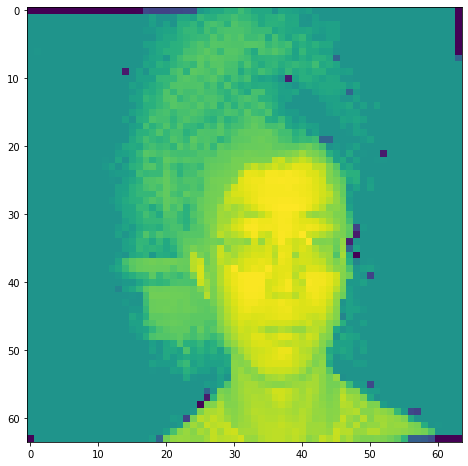

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.imshow(image_data[40][4])
plt.show()

2. Computing the LBP-TOP feature vectors for each video in the dataset

In [52]:
# Function to compute LBP for a given image
def compute_lbp(image, radius, n_points):
    return local_binary_pattern(image, n_points, radius, method='nri_uniform')


In [53]:
n_bins = 59
lbp_top_vectors = []
for video in image_data:
    video = np.array(video)
    # 1. LBP on XY plane (regular LBP on each frame)
    num_frames, height, width = video.shape
    xy_lbp_histograms = []

    for frame in video:
        lbp = compute_lbp(frame, radius, n_points)
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        hist = hist.astype(float) / hist.sum()
        xy_lbp_histograms.append(hist)

    xy_lbp_histograms = np.array(xy_lbp_histograms)
    xy_lbp_histogram = np.mean(xy_lbp_histograms, axis=0)  # Average histogram over all frames

    # 2. LBP on XT plane (variation along x-axis over time for all rows)
    xt_lbp_histograms = []
    for row in range(height):  # Iterate over each row
        xt_planes = video[:, row, :]  # Get XT plane for this row
        xt_lbp = compute_lbp(xt_planes, radius, n_points)
        hist, _ = np.histogram(xt_lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        hist = hist.astype(float) / hist.sum()
        xt_lbp_histograms.append(hist)

    xt_lbp_histograms = np.array(xt_lbp_histograms)
    xt_lbp_histogram = np.mean(xt_lbp_histograms, axis=0)  # Average histogram over all rows

    # 3. LBP on YT plane (variation along y-axis over time for all columns)
    yt_lbp_histograms = []
    for col in range(width):  # Iterate over each column
        yt_planes = video[:, :, col]  # Get YT plane for this column
        yt_lbp = compute_lbp(yt_planes, radius, n_points)
        hist, _ = np.histogram(yt_lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        hist = hist.astype(float) / hist.sum()
        yt_lbp_histograms.append(hist)

    yt_lbp_histograms = np.array(yt_lbp_histograms)
    yt_lbp_histogram = np.mean(yt_lbp_histograms, axis=0)  # Average histogram over all columns

    # Concatenate the histograms to form LBP-TOP feature vector for the video
    lbp_top_vector = np.concatenate([xy_lbp_histogram, xt_lbp_histogram, yt_lbp_histogram])
    lbp_top_vectors.append(lbp_top_vector)
print(len(lbp_top_vectors))

480


In [54]:
print(len(lbp_top_vectors[0]))
print(lbp_top_vectors[0])

177
[0.03024631 0.00881619 0.00280762 0.00949436 0.00211589 0.00813802
 0.00116645 0.01033529 0.00128852 0.00606283 0.00880263 0.00557454
 0.00409614 0.00751411 0.00505914 0.00375705 0.00419108 0.01510959
 0.01771376 0.01671007 0.0046658  0.01992459 0.01513672 0.01265462
 0.00393338 0.01038954 0.03260634 0.03177897 0.00826009 0.0109592
 0.03573947 0.02662489 0.00834147 0.01249186 0.00528971 0.04440647
 0.00762261 0.01631673 0.01159668 0.03997125 0.00519477 0.00341797
 0.00503201 0.00568305 0.00748698 0.00527615 0.00443522 0.00752767
 0.00564236 0.00453016 0.00759549 0.00477431 0.00577799 0.00626628
 0.00613064 0.00556098 0.00528971 0.30913628 0.06753201 0.03266059
 0.01152886 0.00147841 0.01463487 0.00089518 0.0102946  0.00097656
 0.01397027 0.00131565 0.00839572 0.00816515 0.00180393 0.00118001
 0.00793457 0.00770399 0.00101725 0.00170898 0.01494683 0.02612305
 0.01586914 0.00047472 0.01509603 0.02638075 0.01317003 0.00033908
 0.00126139 0.03016493 0.02544488 0.00139703 0.00093587 0.0

## Machine learning models for classification

In [55]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

1. Split the data to training and testing sets

In [56]:
# Random split
X_train, X_test, y_train, y_test = train_test_split(lbp_top_vectors, labels, test_size=0.2, random_state=42)

2. Perform PCA

In [57]:
from PCA import PCA

#Reduced dimensionality for LBP features
dim = 20

#Extracting the subspace

pca_v = PCA(dim)
pca_v.fit(np.array(X_train))

#Transform training_data and testing data respectively
X_train_trans = pca_v.transform(X_train)
X_test_trans = pca_v.transform(X_test)

3. Normalize features

In [58]:
from scipy import stats

training_data_normalized = stats.zscore(X_train_trans, axis=0)
testing_data_normalized = stats.zscore(X_test_trans, axis=0)


4. Tune model parameters

In [313]:
# define the parameter grid
from sklearn.model_selection import GridSearchCV


param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='rbf')
grid_search = GridSearchCV(svm, 
                           param_grid, 
                           cv=3, 
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
 
print(
    "Best parameters are {} \nScore : {}%".format(
        grid_search.best_params_, grid_search.best_score_*100)
)

Best parameters are {'C': 10, 'gamma': 10} 
Score : 35.86368110236221%


5. Train the models

In [63]:
#SVM
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_trans, y_train)

SVC(kernel='linear')

6. Predict on the training and testing sets

In [64]:
y_pred_train_svm = svm_model.predict(X_train_trans)
y_pred_test_svm = svm_model.predict(X_test_trans)

7. Evaluating the model performances

In [65]:
#Training data
print("Accuracy:", accuracy_score(y_train, y_pred_train_svm))
#print("Classification Report:\n", classification_report(y_train, y_pred_train_svm))
print("Training data confusion matrix: \n", confusion_matrix(y_train, y_pred_train_svm))

Accuracy: 0.17447916666666666
Training data confusion matrix: 
 [[ 2  0 64  0  0  0]
 [ 2  0 61  0  0  0]
 [ 4  0 65  0  0  0]
 [ 2  0 58  0  0  0]
 [ 3  0 58  0  0  0]
 [ 1  0 64  0  0  0]]


In [66]:
#Testing data
print("Accuracy:", accuracy_score(y_test, y_pred_test_svm))
#print("Classification Report:\n", classification_report(y_test, y_pred_test_svm))
print("Testing data confusion matrix: \n", confusion_matrix(y_test, y_pred_test_svm))

Accuracy: 0.11458333333333333
Testing data confusion matrix: 
 [[ 0  0 14  0  0  0]
 [ 0  0 17  0  0  0]
 [ 0  0 11  0  0  0]
 [ 0  0 20  0  0  0]
 [ 0  0 19  0  0  0]
 [ 0  0 15  0  0  0]]


In [22]:
print(y_pred_test_svm)
print(y_test)

[3 3 5 0 4 5 1 1 4 0 1 0 3 4 2 4 4 5 4 5 5 4 0 0 5 5 5 3 1 3 5 5 0 4 2 0 0
 0 1 3 3 2 1 0 0 0 5 4 0 5 1 1 0 0 5 5 1 4 5 3 3 5 4 5 3 4 1 0 1 2 5 0 1 0
 5 4 1 1 1 0 0 5 0 1 5 1 1 0 2 3 0 1 5 4 5 1]
[3 3 5 0 0 5 5 5 4 3 4 4 3 2 4 2 0 5 4 0 2 3 4 4 0 5 5 3 1 3 2 2 1 5 1 5 0
 0 4 3 3 3 1 0 1 4 3 0 3 5 0 4 3 1 5 5 1 1 2 3 5 5 3 4 3 0 4 3 5 4 5 1 5 2
 5 3 1 4 1 2 0 2 0 2 5 2 1 4 1 0 0 2 0 2 2 3]
